In [2]:
import os
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image_dataset_from_directory

### Data loading

In [29]:
PATH = os.getcwd()
train_dir = os.path.join(PATH, 'data', 'all')

BATCH_SIZE = 10
IMG_SIZE = (160, 160)

full_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 1449 files belonging to 2 classes.


### See image samples

In [69]:
# To see samples of the images change this to True
SEE_SAMPLE = False

if SEE_SAMPLE:
    class_names = full_dataset.class_names

    plt.figure(figsize=(10, 10))
    for images, labels in full_dataset.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")

### Create validation and test sets

Training set:   70% <br>
Validation set: 15% <br>
Test set:       15%


In [31]:
DATASET_SIZE = int(tf.data.experimental.cardinality(full_dataset))
train_size = int(0.7 * DATASET_SIZE)
val_size = int(0.15 * DATASET_SIZE)
test_size = int(0.15 * DATASET_SIZE)

train_dataset = full_dataset.take(train_size)
test_dataset = full_dataset.skip(train_size)
validation_dataset = test_dataset.skip(val_size)
test_dataset = test_dataset.take(test_size)

In [32]:
print('Number of train batches: %d' % tf.data.experimental.cardinality(train_dataset))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of train batches: 101
Number of validation batches: 23
Number of test batches: 21


### Improve performance

See doc: https://www.tensorflow.org/guide/data_performance

In [33]:
PERF = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=PERF)
validation_dataset = validation_dataset.prefetch(buffer_size=PERF)
test_dataset = test_dataset.prefetch(buffer_size=PERF)

### Augment pictures by shifting and rotating

In [34]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

### Visualise augmentations

In [ ]:
# Visualise augmentations
# If visualise is True this will show a random example of picture augmentation
VISUALIZE = False

if VISUALIZE:
    for image, _ in train_dataset.take(1):
        plt.figure(figsize=(10, 10))
        first_image = image[0]
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
            plt.imshow(augmented_image[0] / 255)
            plt.axis('off')

### Rescale pixel values to [-1,1] because MobileNet_v2 uses residuals

Note: See publication: https://arxiv.org/abs/1801.04381

In [70]:
# Here we use the in-built preprocessing funciton of mobilenet_v2 which rescales the pixel range automatically
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

## Load base model

In [36]:
# Download the pretrained weights from imagenet
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [37]:
# Convert 160x160x3 into 5x5x1280
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(10, 5, 5, 1280)


### Make base model untrainable

In [38]:
base_model.trainable = False

### Model Summary

In [39]:
# base_model.summary()

### Add layers

In [40]:
# Add average pooling layer for conversion of each datapoint to 1x1280
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(10, 1280)


In [41]:
# Add dense layer for binary classification
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(10, 1)


## Model Pipeline

In [53]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)             # Augmentation of data
x = preprocess_input(x)                   # Rescaling pixel layer (0,255 -> -1,1)
x = base_model(x, training=False)         # Pretrained weights layers
x = global_average_layer(x)               # Pooling layer
x = tf.keras.layers.Dropout(0.2)(x)       # Add dropout layer to reduce overfitting
outputs = prediction_layer(x)             # Dense layer for prediction
model = tf.keras.Model(inputs, outputs)

### Compile model

In [55]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

# model.summary()
# len(model.trainable_variables)

## Train Model

### See initial results

In [56]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(train_dataset)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

101/101 [==============================] - 7s 70ms/step - loss: 0.8028 - accuracy: 0.5040
initial loss: 0.80
initial accuracy: 0.50


### Fit training dataset to model with #initial_epocs

In [57]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
101/101 [==============================] - 13s 124ms/step - loss: 0.7690 - accuracy: 0.5436 - val_loss: 0.6424 - val_accuracy: 0.6157
Epoch 2/10
101/101 [==============================] - 13s 128ms/step - loss: 0.6343 - accuracy: 0.6416 - val_loss: 0.5658 - val_accuracy: 0.7162
Epoch 3/10
101/101 [==============================] - 13s 132ms/step - loss: 0.5451 - accuracy: 0.7168 - val_loss: 0.4887 - val_accuracy: 0.8035
Epoch 4/10
101/101 [==============================] - 12s 122ms/step - loss: 0.4951 - accuracy: 0.7505 - val_loss: 0.4532 - val_accuracy: 0.8210
Epoch 5/10
101/101 [==============================] - 13s 126ms/step - loss: 0.4543 - accuracy: 0.7743 - val_loss: 0.4089 - val_accuracy: 0.8297
Epoch 6/10
101/101 [==============================] - 13s 132ms/step - loss: 0.4185 - accuracy: 0.7931 - val_loss: 0.3610 - val_accuracy: 0.8559
Epoch 7/10
101/101 [==============================] - 13s 133ms/step - loss: 0.3961 - accuracy: 0.7931 - val_loss: 0.3691 - val_ac

## Graphing results function

### Result graphs

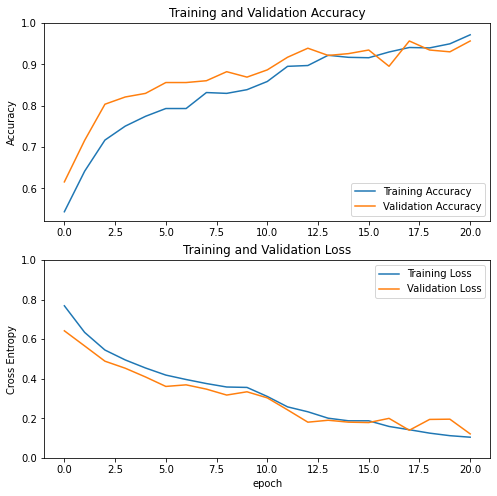

In [73]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Retrain some middle layers to slightly improve accuracy

In [59]:
base_model.trainable = True

In [60]:
# There are 155 layers in the base model
# print("Number of layers: ", len(base_model.layers))

# Train from this layer on
train_up_to = 100

# Make all layers before untrainable
for layer in base_model.layers[:train_up_to]:
    layer.trainable =  False

### Compile model again

In [61]:
# Here we use a learning rate 10 times lower to avoid overfitting
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

# model.summary()

### Train model again

In [62]:
new_epochs = 10
total_epochs =  initial_epochs + new_epochs
history_new = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
101/101 [==============================] - 18s 183ms/step - loss: 0.3104 - accuracy: 0.8584 - val_loss: 0.3032 - val_accuracy: 0.8865
Epoch 11/20
101/101 [==============================] - 19s 188ms/step - loss: 0.2577 - accuracy: 0.8950 - val_loss: 0.2424 - val_accuracy: 0.9170
Epoch 12/20
101/101 [==============================] - 19s 189ms/step - loss: 0.2328 - accuracy: 0.8970 - val_loss: 0.1802 - val_accuracy: 0.9389
Epoch 13/20
101/101 [==============================] - 20s 198ms/step - loss: 0.2004 - accuracy: 0.9218 - val_loss: 0.1899 - val_accuracy: 0.9214
Epoch 14/20
101/101 [==============================] - 18s 183ms/step - loss: 0.1872 - accuracy: 0.9168 - val_loss: 0.1804 - val_accuracy: 0.9258
Epoch 15/20
101/101 [==============================] - 19s 187ms/step - loss: 0.1872 - accuracy: 0.9158 - val_loss: 0.1782 - val_accuracy: 0.9345
Epoch 16/20
101/101 [==============================] - 18s 182ms/step - loss: 0.1586 - accuracy: 0.9297 - val_loss: 0.1995 -

In [74]:
acc += history_new.history['accuracy']
val_acc += history_new.history['val_accuracy']

loss += history_new.history['loss']
val_loss += history_new.history['val_loss']

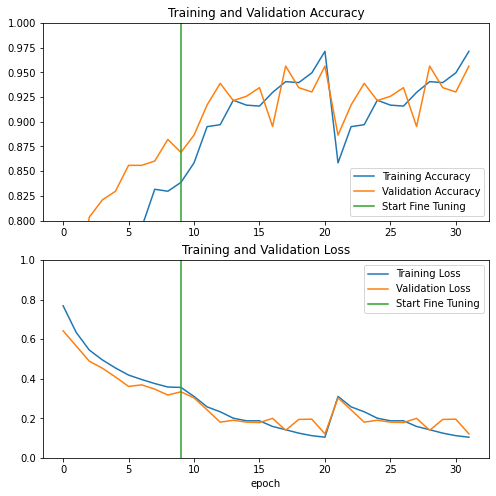

In [76]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Evaluation

In [63]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

21/21 [==============================] - 2s 76ms/step - loss: 0.1521 - accuracy: 0.9476
Test accuracy : 0.9476190209388733


# Save model

In [77]:
model.save('model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model/assets
